# Quick Start With TciaDataset

[The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a service which de-identifies and hosts a large archive of medical images. In this tutorial, we will introduce how to use `TciaDataset` to automatically download and extract the TCIA datasets, and act as PyTorch datasets to generate training/validation/test data.

<p align="center">
  <img src="../figures/TCIA_LOGO.png" alt="tcia logo">
</p>

We'll cover the following topics in this tutorial:
* Access a dataset(collection) from TCIA with TciaDataset
* Visualize images and masks from the dataset
* Create training experiment with TciaDataset

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, pillow, ignite, tqdm, pydicom]"
!python -c "import matplotlib" || pip install -q matplotlib

In [ ]:
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandFlipd,
    Spacingd,
    NormalizeIntensityd,
    ResampleToMatchd,
)
import monai
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.apps import TciaDataset
from monai.apps.tcia import TCIA_LABEL_DICT
from monai.data import DataLoader, decollate_batch
import os
import tempfile
import shutil
import torch
import matplotlib.pyplot as plt

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Brief Introduction

TCIA provides The National Biomedical Imaging Archive (NBIA) REST APIs, which allows you to query the collections information such as collection name, abstract, image modalities, how many subjects/scans/images, DOI/URL of the Collection page that describes the data in detail. Please follow the [guide](https://wiki.cancerimagingarchive.net/display/Public/NBIA+Search+REST+API+Guide) for more details.

## Create TciaDataset

For a collection that contains image with type `SEG` or `RESTRUCT`, `TciaDataset` (inherits from MONAI `CacheDataset`) can be utilized to download the dataset and load images. `TciaDataset` includes some of the NBIA APIs, and provides rich parameters to achieve expected behavior. Some of the main parameters include:
1. **root_dir**: target directory to download and load TCIA dataset.
1. **collection**: name of collection (dataset)
1. **download**: whether to download and extract the dataset first.
1. **download_len**: number of series that will be downloaded. Sometimes only download a few series is enough. If not specified, the whole dataset will be downloaded.
1. **seg_type**: modality type of segmentation that is used to do the first step download (two steps download will be introduced bellow)
1. **modality_tag**: tag of modality.
1. **ref_series_uid_tag**: tag of referenced Series Instance UID.
1. **ref_sop_uid_tag**: tag of referenced SOP Instance UID.

After downloading (if specified, all images and "seg_type" data (such as "SEG", "RTSTRUCT") will be stored locally for further usage.

<p align="center">
  <img src="../figures/tcia_download_steps.png" alt="tcia download steps">
</p>

In [ ]:
# Let's take the "QIN-PROSTATE-Repeatability" collection for example
collection, seg_type = "QIN-PROSTATE-Repeatability", "SEG"

# use the `LoadImaged` transform to load data, `label_dict` is used to unify the label order
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"], label_dict=TCIA_LABEL_DICT[collection]),
    ]
)

In [ ]:
ds = TciaDataset(
    root_dir=root_dir,
    collection=collection,
    section="training",
    download=True,
    seg_type=seg_type,
    progress=False,
    cache_rate=0.0,
    val_frac=0.2,
    transform=transform,
)

### Detect dataset

In [ ]:
sample = 0

ds[sample]["image"].affine

In [ ]:
ds[sample]["seg"].affine

In [ ]:
print(ds[sample]["image"].shape, ds[sample]["seg"].shape)

As we can see from the metadata, the affine matrixes between images and segmentations have some differences: the direction of the third spatial dimension is opposite.

We can use the `ResampleToMatchd` transform to unify them.
In addition, images do not have the channel dimension, and the channel dimension of segmentations can be adjusted into the first dimension. We can use the `EnsureChannelFirstd` to address this issue

### Add pre-processing transforms and reload

In [ ]:
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"], label_dict=TCIA_LABEL_DICT[collection]),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResampleToMatchd(keys="image", key_dst="seg"),
    ]
)

ds = TciaDataset(
    root_dir=root_dir,
    collection=collection,
    section="training",
    download=False,
    seg_type=seg_type,
    progress=False,
    cache_rate=0.0,
    val_frac=0.2,
    transform=transform,
)

In [ ]:
sample = 0

ds[sample]["image"].affine

In [ ]:
ds[sample]["seg"].affine

In [ ]:
print(ds[sample]["image"].shape, ds[sample]["seg"].shape)

As we can see, now the affine matrixes for images and segmentations are identical.

### Visualize and check

In [ ]:
# from W, H, D to D, H, W
img = ds[4]["image"].numpy().transpose([0, 3, 2, 1])
seg = ds[4]["seg"].numpy().transpose([0, 3, 2, 1])

In [ ]:
every_n = 10
fig_seg = monai.visualize.matshow3d(img[0], show=True, every_n=every_n)

In [ ]:
fig_seg = monai.visualize.matshow3d(seg[3], show=True, every_n=every_n)

## Create a Training Pipeline

### Define CacheDataset and DataLoader for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"],
                   label_dict=TCIA_LABEL_DICT[collection], image_only=True),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResampleToMatchd(keys="image", key_dst="seg"),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        Spacingd(keys=["image", "seg"], pixdim=(
            1.0, 1.0, 0.5), mode=("bilinear", "nearest")),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["image", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 64),
            pos=1,
            neg=1,
            num_samples=2,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(keys=("image", "seg"), prob=0.5, spatial_axis=[0]),
        RandFlipd(keys=("image", "seg"), prob=0.5, spatial_axis=[1]),
        RandScaleIntensityd(keys="image", factors=(-0.2, 0.2), prob=0.5),
        RandShiftIntensityd(keys="image", offsets=(-0.1, 0.1), prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"],
                   label_dict=TCIA_LABEL_DICT[collection], image_only=True),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResampleToMatchd(keys="image", key_dst="seg"),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        Spacingd(keys=["image", "seg"], pixdim=(
            1.0, 1.0, 0.5), mode=("bilinear", "nearest")),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

train_ds = TciaDataset(
    root_dir=root_dir,
    collection=collection,
    section="training",
    download=False,
    seg_type=seg_type,
    progress=True,
    cache_rate=1.0,
    val_frac=0.2,
    transform=train_transforms,
)

val_ds = TciaDataset(
    root_dir=root_dir,
    collection=collection,
    section="training",
    download=False,
    seg_type=seg_type,
    progress=True,
    cache_rate=1.0,
    val_frac=0.2,
    transform=val_transforms,
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
# there are 4 labels, and for the example here, we will only focus on "WholeGland".

print(train_ds[0][0]["seg"].meta["labels"])

### Create Model, Loss, Optimizer

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="batch",
).to(device)
loss_function = DiceCELoss(sigmoid=True, include_background=True, batch=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
max_epochs = 1000
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
dice_metric = DiceMetric(include_background=True, reduction="mean")
selected_label = 3

### Execute a typical PyTorch training process

In [ ]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["seg"][:, selected_label:selected_label + 1, ...].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["seg"][:, selected_label:selected_label + 1, ...].to(device),
                )
                roi_size = (96, 96, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

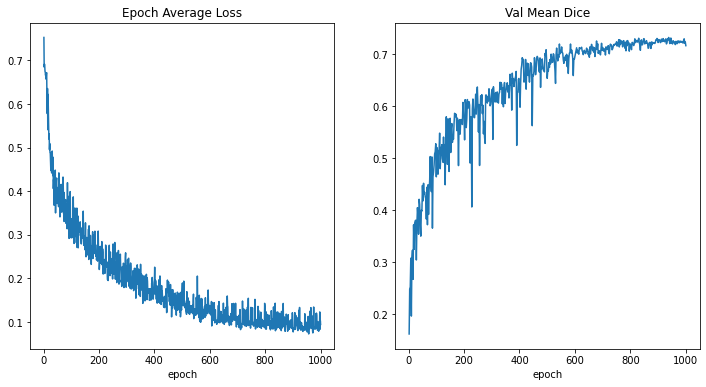

In [27]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

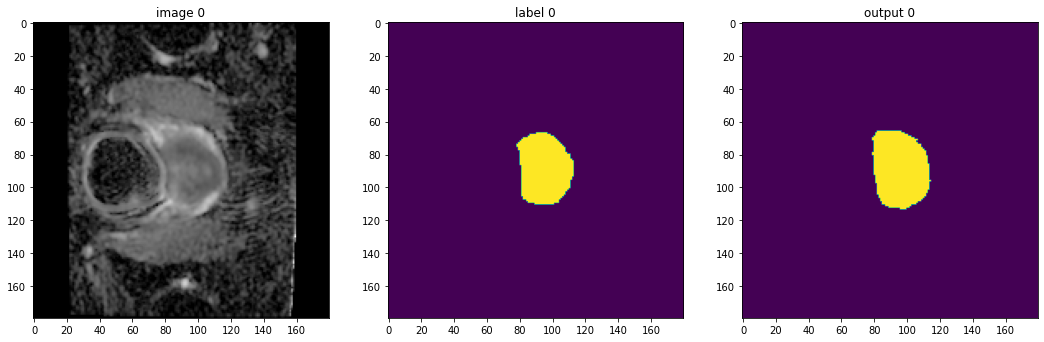

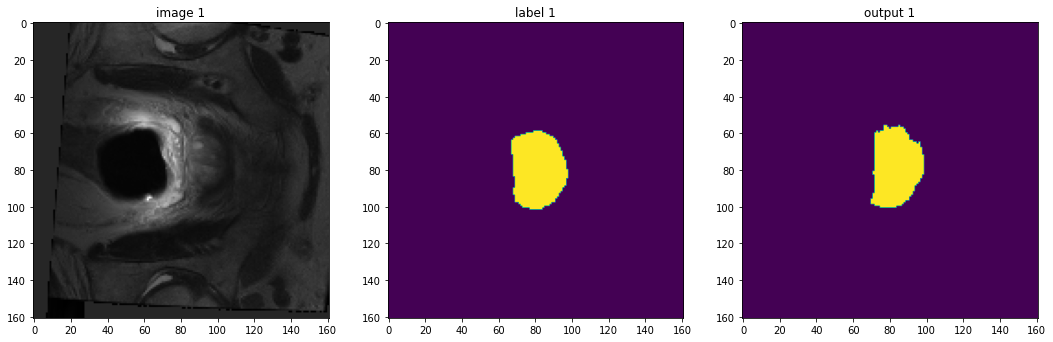

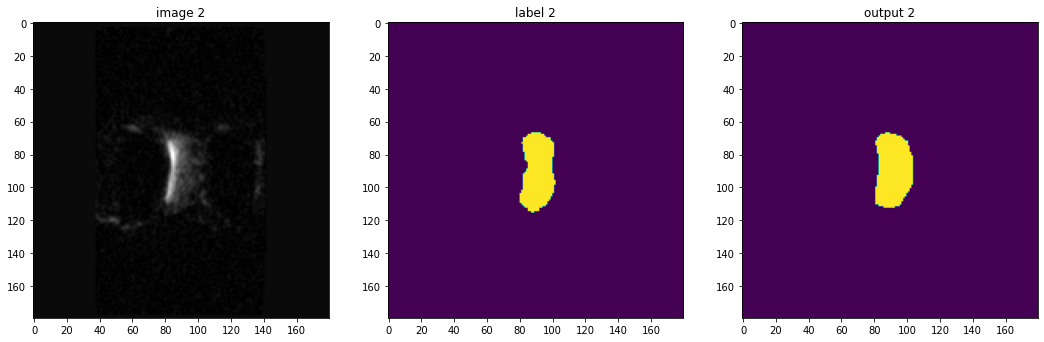

In [29]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        depth = val_data["image"].shape[-1]
        slc = depth // 2
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, slc], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["seg"][0, selected_label, :, :, slc])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(post_pred(val_outputs[0]).detach().cpu()[0, :, :, slc])
        plt.show()
        if i == 2:
            break

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)

# Acknowledgments

[QIN-Prostate-Repeatability](https://wiki.cancerimagingarchive.net/display/Public/QIN-PROSTATE-Repeatability) dataset used in this notebook is described in the following publications:

* Fedorov A, Vangel MG, Tempany CM, Fennessy FM. Multiparametric Magnetic Resonance Imaging of the Prostate: Repeatability of Volume and Apparent Diffusion Coefficient Quantification. Investigative Radiology. 52, 538–546 (2017). DOI: [10.1097/RLI.0000000000000382](https://doi.org/10.1097/RLI.0000000000000382)

* Fedorov, A., Schwier, M., Clunie, D., Herz, C., Pieper, S., Kikinis,R., Tempany, C. & Fennessy, F. An annotated test-retest collection of prostate multiparametric MRI. Scientific Data 5, 180281 (2018). DOI: 
[10.1038/sdata.2018.281](https://doi.org/10.1038/sdata.2018.281)

Dataset used in this notebook was retrieved from The Cancer Imaging Archive, which is described in the following publication:

* Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057. DOI: [10.1007/s10278-013-9622-7](https://dx.doi.org/10.1007%2Fs10278-013-9622-7)
